### Using recurrent neural networks for the analysis of behavioural data
##### Amir Dezfouli

### Background
In this tutorial, I will present how to use recurrent neural networks (RNNs) for the analysis of behavioural data. In this setting, we have the behaviour of a set of subjects in a task and the aim is to have a computational model for the subjects' choice processes. This kind of data is often analysed using reinforcement-learning models such as Q-learning. A potential problem with this approach is that the model development is mainly intuition-driven and the model needs to be manually engineered to match the actual underlying behavioural trends in the data. RNNs, on the other hand, are flexible and fit the data <i>automatically</i> without requiring engineering, but they may be hard to interpret. In [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006903), we showed that RNNs provide a better fit to the data compared to the baseline reinforcement-learning models. The code of the paper is available in this [link](https://github.com/adezfouli/rnn_beh), using `Tensorflow==1.3`. In this tutorial, I will show how to fit a recurrent neural network to the behavioural data using `Tensroflow 2` and `keras`, which are easier to work with compared to the earlier versions of `Tensroflow`.

### Recurrent neural networks
The model is composed of a set of RNN cells, which then through a softmax layer make predictions for the probability of selecting each action in the next trial. In the context of the behavioural data that we are interested in, at each trial $t$, the model takes the previous action $a_{t-1}$, the reward received by taking the action ($r_{t-1}$), and the current state of the world ($s_t$) as an input, and then produces predictions for the probability of taking each action in the next trial. For example, in the case of binary bandits with two actions, the model predicts the probability of taking action L and R. The predictions of the model are then used to build a loss function $\mathcal{L}$ , which is used to train the model. Note that in the case of bandit tasks there is no state information.

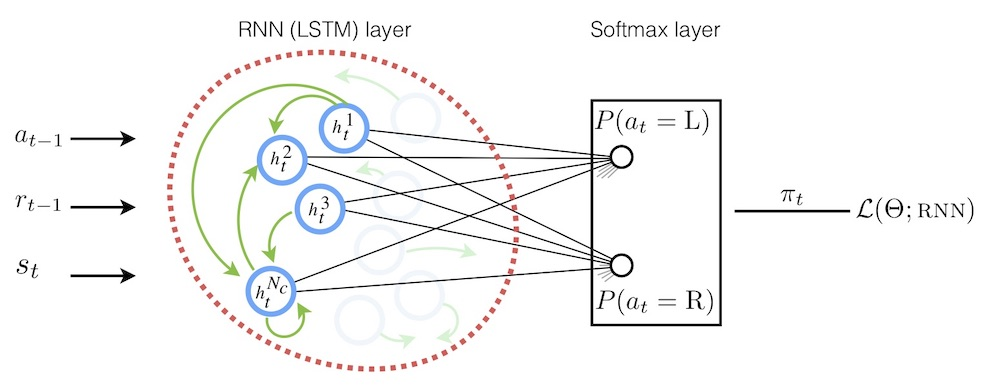

### Requirements
The code is based on `tensorflow==2.0.0-beta1`. See [here](https://www.tensorflow.org/install/pip) for the details of installation. For loading data `h5py` package is used which can be installed using `pip`. For splitting data into train and test, `sklearn` is used, which again can be used using `pip`.

### Loading and preparing data
The data is in file `data/BD-healthy.hdf5`,

In [71]:
import h5py
import numpy as np
with h5py.File('data/BD-healthy.hdf5', 'r') as f:
    # loading actions taken by the subjects
    action = f['action'][:].astype(np.int32)
    
    # loading rewards received by the subjects
    reward = f['reward'][:].astype(np.float32)
    
from sklearn.model_selection import train_test_split
# generating test and training data
action_train, action_test, reward_train, reward_test = train_test_split(action, reward, test_size=0.2)

`action` and `reward` are both matrices with S x T dimensions, in which S is the number of subjects and T is the number of trials. Actions are coded as integers (0, 1, ...). The number of completed trials can be different for each subject, in which case the actions at the empty trials at the end of the task are coded by -1. 

We convert the actions into one-hot format,

In [72]:
from tensorflow import one_hot
action_onehot = one_hot(action_train, 2) # action 0 is coded as [1, 0], and action 1 is coded as [0, 1], and -1 is coded as [0, 0]

Actions and rewards are then concatenated to form the input to the model. Note that a dummy action and reward is added to the beginning of the data,

In [73]:
from tensorflow.python.keras.layers import Concatenate, ZeroPadding1D
reward_action = Concatenate(axis=2)([reward_train[:, :, np.newaxis], action_onehot])

# adding dummy zero to the beginning and ignoring the last one
reward_action = ZeroPadding1D(padding=[1, 0])(reward_action)[:, :-1, :]


### Defining the model
We first define the model. For simplicity we focus on the modelling of bandit tasks, in which there is no state information and therefore the model only receives input $a_{t-1}$ and $r_{t-1}$,

In [74]:
import tensorflow as tf
import tensorflow.keras.layers as kl

n_actions = 2    # there are two actions
state_size = 0   # there is only state in the bandit task, so we don't pass the state information to the model
n_cells = 5      # number of cells in the recurrent neural network

# inputs to the model. Dim: S x T x (1 + n_actions + state_size).
model_inputs = tf.keras.Input(shape=(None, 1 + n_actions + state_size), name='reward_action')

# initial state of the RNN, Dim: S x n_cells
rnn_initial_state = tf.keras.Input(shape=(n_cells,), name='initial_state')

# output of the recurrent nerual network. Dim: S x T x n_cells
rnn_out = kl.GRU(n_cells, return_sequences=True, name='GRU')(model_inputs, initial_state=rnn_initial_state)

# policy -- probablity of taking each action. Dim: S x T x n_actions
policy = kl.Dense(n_actions, activation='softmax', name='policy')(rnn_out)

# defining the model
model = tf.keras.Model(inputs=[model_inputs, rnn_initial_state], outputs=policy, name='model')

# this model will be used for off-policy simulations in which we need to track rnn state
sim_model = tf.keras.Model(inputs=[model_inputs,rnn_initial_state], outputs=[rnn_out, policy])


### Optimising the model

In [75]:
import tensorflow as tf
import tensorflow.keras.backend as kb
from tensorflow.python.keras.losses import categorical_crossentropy

# defining the optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# initial state of RNN
initial_rnn_state = np.zeros((reward_action.shape[0], n_cells,), dtype=np.float32)

# defining loss
def loss(y_true, y_pred):
    return kb.sum(categorical_crossentropy(y_true, y_pred))


model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print('started model fitting... (please wait)')

# training the model. Change verbose to 2 to see training process
model.fit([reward_action, initial_rnn_state], action_onehot, epochs=2000, batch_size=reward_action.shape[0], verbose=0)
print('finished model fitting.')

started model fitting... (please wait)
finished model fitting.


### Testing the model
We use the test datat to evaluate the loss,

In [76]:
action_onehot = one_hot(action_test, 2)
reward_action = Concatenate(axis=2)([reward_test[:, :, np.newaxis], action_onehot])

# adding dummy zero to the beginning and ignoring the last one
reward_action = ZeroPadding1D(padding=[1, 0])(reward_action)[:, :-1, :]

model.evaluate([reward_action, initial_rnn_state], action_onehot, batch_size=reward_action.shape[0])


82/82 [==============================] - 0s 3ms/sample - loss: 2108.8633 - accuracy: 0.5527


[2108.86328125, 0.55271226]

### Off-policy model simulation
In this section we show how to simulate the model off-policy. Off-policy simulations are useful to see how the predictions of the model change under different input conditions. The simulation is for 30 trials. In the first 10 trials the taken action is '0' and then it becomes '1' for the rest of the trials. The reward is delivered at trials 4, 14, 22, 27,

In [77]:
action_onehot = one_hot(np.array([0] * 10 + [1] * 20)[np.newaxis,], 2)
reward = np.zeros((1, 30), dtype=np.float32)
reward[:, [4, 14, 22, 27]] = 1

# concatinating action and reward and them to RNN as input
reward_action = Concatenate(axis=2)([reward[:, :, np.newaxis], action_onehot])

# adding dummy zeros to the beginning and ignoring the last one
reward_action = ZeroPadding1D(padding=[1, 0])(reward_action)[:, :-1, :]

# initial state of RNN
initial_rnn_state = np.zeros((reward_action.shape[0], n_cells,), dtype=np.float32)

# getting model policy
_, policy = sim_model([reward_action, initial_rnn_state])


We can then plot the policy,

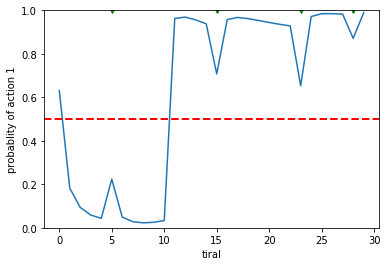

In [78]:
import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlabel('tiral')
plt.ylabel('probablity of action 1')
plt.plot(np.arange(policy.shape[1]), policy[0, :, 1])
plt.axhline(y=0.5, linewidth=2, color = 'red', linestyle="dashed") 
plt.plot(5,1, marker="v", color='green')
plt.plot(15, 1, marker="v", color='green')
plt.plot(23, 1, marker="v", color='green')
plt.plot(28, 1, marker="v", color='green')


### On-policy model simulation
In on-policy simulations, the actions are taken by the model. Assume that the probability of earning a reward from the first action is 0.1 and the probability of earning a reward from the second action is 0.3. We aim to simulate the model in the task for 200 trials,

0.6916120046307332


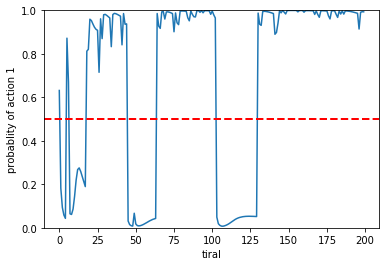

In [80]:
# this is same as the model that we defined earlier, but it 

L_p = 0.02
R_p = 0.3


# initial actions and rewards
action_onehot = np.zeros([1, 1, 2], dtype=np.float32)
reward = np.zeros((1, 1, 1), dtype=np.float32)
reward_action = Concatenate(axis=2)([reward, action_onehot])

# initial state of RNN
rnn_state = np.zeros((reward_action.shape[0], n_cells,), dtype=np.float32)

policies = np.zeros((200,))

# getting model policy
for t in range(policies.shape[0]):
    
    # getting the policy
    rnn_state, policy = sim_model([reward_action, rnn_state])
    policies[t] = np.squeeze(policy)[1]
    
    # gettig the last state of RNN
    rnn_state = rnn_state[:, 0, :]

    # sampling the actions and rewards
    action_onehot = np.zeros([1, 1, 2], dtype=np.float32)
    if np.random.random() < np.squeeze(policy)[0]:
        action_onehot[0, 0, 0] = 1
        if np.random.random() < L_p:
            reward = np.ones((1, 1, 1), dtype=np.float32)
        else:
            reward = np.zeros((1, 1, 1), dtype=np.float32)
    else:
        action_onehot[0, 0, 1] = 1
        if np.random.random() < R_p:
            reward = np.ones((1, 1, 1), dtype=np.float32)
        else:
            reward = np.zeros((1, 1, 1), dtype=np.float32)

    reward_action = Concatenate(axis=2)([reward, action_onehot])


print(policies.mean())

# drawing policies
import matplotlib.pyplot as plt
plt.ylim((0,1))
plt.xlabel('tiral')
plt.ylabel('probablity of action 1')
plt.plot(np.arange(policies.shape[0]), policies)
plt.axhline(y=0.5, linewidth=2, color = 'red', linestyle="dashed") 



### Data with state information
So far we have focused on the bandit tasks in which state information is not available. In the case that the state information is available (e.g, there are different stimuli in the task), state information can be fed into the model similar to action and reward information. The only difference is, for predicting action at trial $t$, the action and reward information fed to the model are $a_{t-1}$ and $r_{t-1}$, but the state information fed to the model is for trial $t$, i.e, $s_t$ (see Figure 1). 

We first load  as sample data,

In [81]:
import h5py
import numpy as np
with h5py.File('data/data-state.hdf5', 'r') as f:
    # loading actions taken by the subjects
    action = f['action'][:].astype(np.int32)
    
    # loading rewards received by the subjects
    reward = f['reward'][:].astype(np.float32)
    
    # loading state received by the subjects
    state = f['state'][:].astype(np.float32)
    
from tensorflow import one_hot
action_onehot = one_hot(action, 2) # action 0 is coded as [1, 0], and action 1 is coded as [0, 1], and -1 is coded as [0, 0]

# concatinating action and reward and them to RNN as input
reward_action = Concatenate(axis=2)([reward[:, :, np.newaxis], action_onehot])

# adding dummy zeros to the beginning and ignoring the last one
reward_action = ZeroPadding1D(padding=[1, 0])(reward_action)[:, :-1, :]
    
# adding state information
reward_action_state = Concatenate(axis=2)([reward_action, state])
    

Next, we define the model. Note that this is similar to the bandit case, but state_size is 3 instead of zero,

In [82]:
import tensorflow as tf
import tensorflow.keras.layers as kl

n_actions = 2    # there are two actions
state_size = 3   # there is only state in the bandit task, so we don't pass the state information to the model
n_cells = 5      # number of cells in the recurrent neural network

# inputs to the model. Dim: S x T x (1 + n_actions + state_size).
model_inputs = tf.keras.Input(shape=(None, 1 + n_actions + state_size), name='reward_action')

# initial state of the RNN, Dim: S x n_cells
rnn_initial_state = tf.keras.Input(shape=(n_cells,), name='initial_state')

# output of the recurrent nerual network. Dim: S x T x n_cells
rnn_out = kl.GRU(n_cells, return_sequences=True, name='GRU')(model_inputs, initial_state=rnn_initial_state)

# policy -- probablity of taking each action. Dim: S x T x n_actions
policy = kl.Dense(n_actions, activation='softmax', name='policy')(rnn_out)

# defining the model
model = tf.keras.Model(inputs=[model_inputs, rnn_initial_state], outputs=policy, name='model')

# this model will be used for off-policy simulations in which we need to track rnn state
sim_model = tf.keras.Model(inputs=[model_inputs,rnn_initial_state], outputs=[rnn_out, policy])

and then fitting the model,

In [84]:
# defining the optimiser
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

# initial state of RNN
initial_rnn_state = np.zeros((reward_action_state.shape[0], n_cells,), dtype=np.float32)

# defining loss
def loss(y_true, y_pred):
    return kb.sum(categorical_crossentropy(y_true, y_pred))

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print('started model fitting... (please wait)')

# training the model. Change verbose to 2 to see training process. Change ephocs are required
model.fit([reward_action_state, initial_rnn_state], action_onehot, epochs=200, batch_size=reward_action_state.shape[0], verbose=0)
print('finished model fitting.')


started model fitting... (please wait)
finished model fitting.


The rest of the analysis such as simulations can be done similar to the bandit case.

### See also
The model above and materials are based on [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006903),

* Dezfouli, A., Griffiths, K., Ramos, F., Dayan, P., & Balleine, B. W. (2019). Models that learn how humans learn: the case of decision-making and its disorders. PLoS computational biology, 15(6), e1006903.

There are two extensions to this framework. In the [first extension](https://www.biorxiv.org/content/10.1101/658252v1), instead of fitting a single model to the whole group, a different network is learned for each subject using auto-encoders. The reference is below:

* Dezfouli, A., Ashtiani, H., Ghattas, O., Nock, R., Dayan, P., & Ong, C. S. (2019). Disentangled behavioral representations. bioRxiv, 658252.

In the [second extension](https://www.biorxiv.org/content/10.1101/328849v2) to this framework, an RNN is fitted jointly to neural (fMRI) and behavioural data,

* Dezfouli, A., Morris, R., Ramos, F. T., Dayan, P., & Balleine, B. (2018). Integrated accounts of behavioral and neuroimaging data using flexible recurrent neural network models. In Advances in Neural Information Processing Systems (pp. 4228-4237).


